# HW 4

## Problem 1

In [69]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.integrate import quad

In [70]:
h = .7
M_STAR = -21
ALPHA = -1.4
PHI_STAR = .014 * h**3
OMEGA_M = .3
OMEGA_LAMBDA = .7

In [71]:
def chi(zs, Omega_m=OMEGA_M, Omega_lambda=OMEGA_LAMBDA, h=h):
    H_0 = 100*h # [km/s/Mpc]
    def compute_chi(z):
        def f(z):
            return H_0**(-1)*(Omega_m*(1+z)**3 + Omega_lambda)**(-1/2) * 3*10**5
        return quad(f, 0, z,)[0] # returns in Mpc
    
    if np.isscalar(zs):
        return compute_chi(zs)
    else:
        return np.array([compute_chi(z) for z in zs])


def D_L(z, Omega_m=OMEGA_M, Omega_lambda=OMEGA_LAMBDA, h=h):
    return (1+z) * chi(z, Omega_m, Omega_lambda, h)

def Phi(M, M_star=M_STAR, phi_star=PHI_STAR, alpha = ALPHA):
    return .4*np.log(10)*phi_star \
            * 10**(.4*(M_star-M)*(1+alpha)) \
            * np.exp(-10**(.4*(M_star-M)))

Text(0, 0.5, '$\\Phi$ [Mpc$^{-1}$ mag$^{-1}$]')

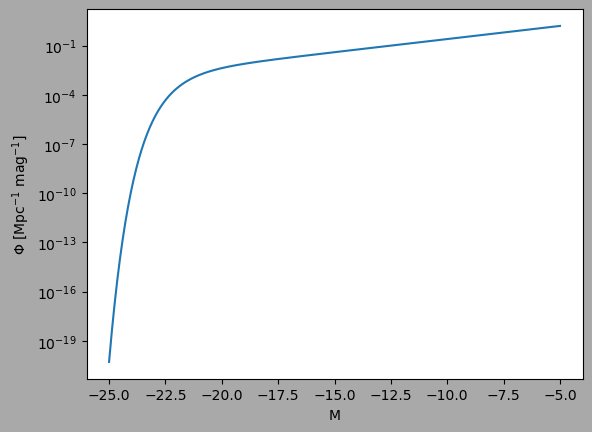

In [72]:
Ms = np.linspace(-25, -5, 500)

fig,ax = plt.subplots()
ax.plot(Ms, Phi(Ms))
ax.set_yscale('log')
fig.set_facecolor('darkgray')
ax.set_xlabel('M')
ax.set_ylabel("$\Phi$ [Mpc$^{-1}$ mag$^{-1}$]")

In [73]:
def M_from_m(m, z, Omega_m=OMEGA_M, Omega_lambda=OMEGA_LAMBDA, h=h):
    d = D_L(z, Omega_m, Omega_lambda, h)
    return m - 25 - 5*np.log10(d) + 2.5*np.log10(1+z)

def n(zs, m_0, Omega_m=OMEGA_M, Omega_lambda=OMEGA_LAMBDA, h=h, \
      M_star = M_STAR, phi_star = PHI_STAR, alpha=ALPHA):
    def compute_n(z):
        M = M_from_m(m_0, z, Omega_m, Omega_lambda, h)
        return quad(Phi, -40, M_from_m(m_0,z), args=(M_star, phi_star, alpha))[0]
    
    if np.isscalar(zs):
        return compute_n(zs)
    else:
        return np.array([compute_n(z) for z in zs])

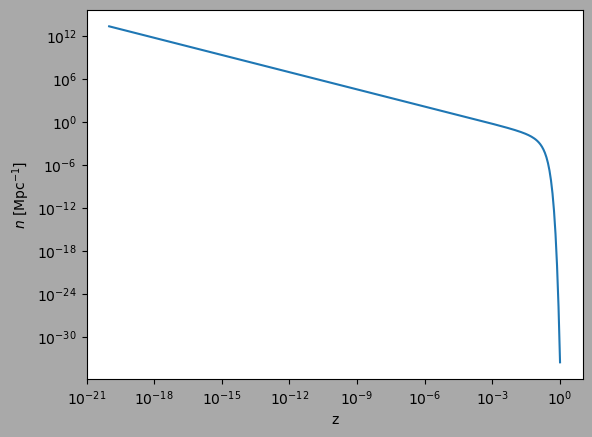

In [74]:
fig,ax = plt.subplots()
fig.set_facecolor('darkgray')
ax.set_xlabel('z')
ax.set_ylabel("$n$ [Mpc$^{-1}$]")

zs = np.logspace(-20,0,300)
m_0 = 17.8
ax.plot(zs, n(zs,m_0))
ax.set_xscale('log')
ax.set_yscale('log')

In [75]:
def H(zs, Omega_m=OMEGA_M, Omega_lambda=OMEGA_LAMBDA, h=h):
    H_0 = 100*h 
    return H_0 * np.sqrt(Omega_m*(1+zs)**3 + Omega_lambda)

def dVdz(zs, Omega_m=OMEGA_M, Omega_lambda=OMEGA_LAMBDA, h=h):
    c = 3e5
    return 4*np.pi*chi(zs)**2 * c / H(zs,Omega_m, Omega_lambda, h)

def dNdz(zs, m_0, Omega_m=OMEGA_M, Omega_lambda=OMEGA_LAMBDA, h=h):
    return n(zs, m_0, Omega_m, Omega_lambda, h) * dVdz(zs, Omega_m, Omega_lambda, h)

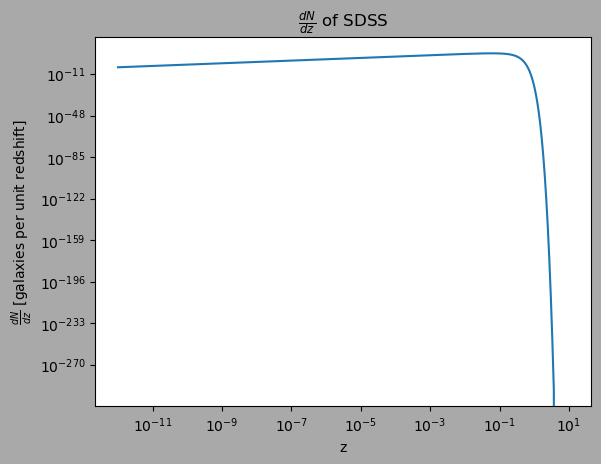

In [76]:
fig,ax = plt.subplots()
fig.set_facecolor('darkgray')
ax.set_xlabel('z')
ax.set_ylabel(r"$\frac{dN}{dz}$ [galaxies per unit redshift]")
ax.set_title(r"$\frac{dN}{dz}$ of SDSS")

m_0 = 17.8
zs = np.logspace(-12,1,300)
plt.plot(zs, dNdz(zs,m_0))
plt.xscale('log')
plt.yscale('log')

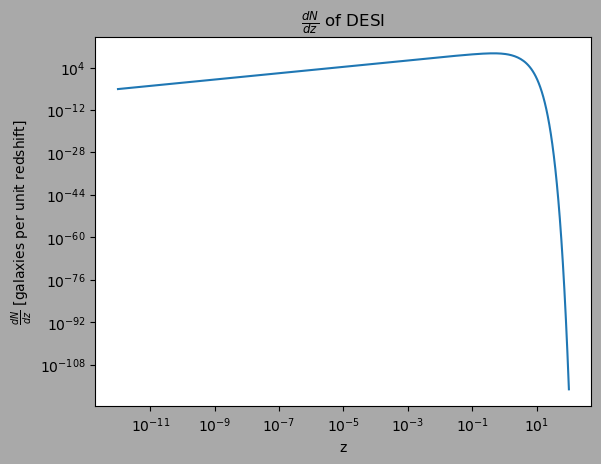

In [77]:
fig,ax = plt.subplots()
fig.set_facecolor('darkgray')
ax.set_xlabel('z')
ax.set_ylabel(r"$\frac{dN}{dz}$ [galaxies per unit redshift]")
ax.set_title(r"$\frac{dN}{dz}$ of DESI")

m_0 = 23.4
zs = np.logspace(-12,2,300)
plt.plot(zs, dNdz(zs,m_0))
plt.xscale('log')
plt.yscale('log')

In [78]:
m_0_DESI = 23.4
m_0_SDSS = 17.8
print(f"At z=.1, DESI can see galaxies of m = {M_from_m(m_0_DESI,.1):.2f}")

At z=.1, DESI can see galaxies of m = -14.81


In [79]:
M_min = -24
M_max = -14
z_min = .1
z_max = 1
volume = 4/3 * np.pi * (chi(z_max)**3 - chi(z_min)**3) * (1/41253)
N = int(quad(Phi, M_min, M_max)[0] * volume) 
print(f"I will be sampling for a total of N={N:.1e} galaxies")

I will be sampling for a total of N=5.1e+05 galaxies


In [80]:
# create a function for generating apropriate M values from random numbers
from scipy.integrate import cumulative_trapezoid
from scipy.interpolate import interp1d

Ms = np.linspace(M_min, M_max, int(1e5))
Phis = Phi(Ms)
phi_cdf_unnorm = cumulative_trapezoid(Phis, Ms, initial=0)

phi_cdf = phi_cdf_unnorm / phi_cdf_unnorm[-1]

M_generator = interp1d(phi_cdf, Ms)

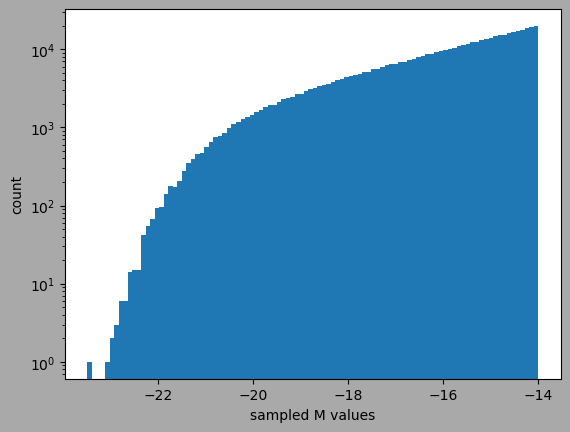

In [81]:
fig,ax = plt.subplots()
fig.set_facecolor('darkgray')
ax.set_xlabel('sampled M values')
ax.set_ylabel(r"count")

random_numbers = np.random.random(N)
M_sample = M_generator(random_numbers)
plt.hist(M_sample,bins=100)
plt.yscale('log')

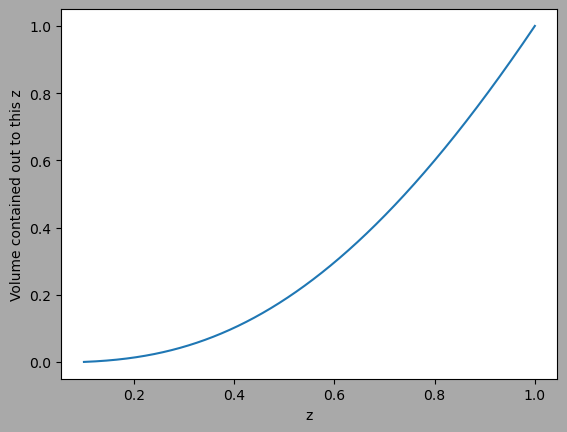

In [82]:
def V_cdf(z, z_min=.1, z_max=1):
    total_V = 4/3 * np.pi * (chi(z_max)**3 - chi(z_min)**3)
    V = 4/3 * np.pi * (chi(z)**3 - chi(z_min)**3)
    return V / total_V

fig,ax = plt.subplots()
fig.set_facecolor('darkgray')
ax.set_xlabel('z')
ax.set_ylabel(r"Volume contained out to this z")

zs = np.linspace(.1, 1, int(1e5))
V_cdf_vals = V_cdf(zs)
plt.plot(zs, V_cdf_vals)

z_generator = interp1d(V_cdf_vals, zs)

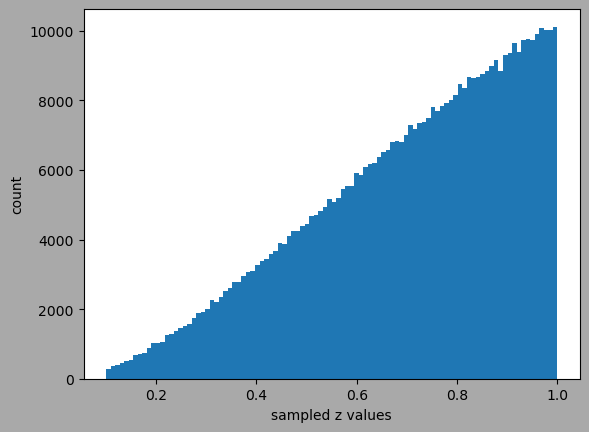

In [83]:
fig,ax = plt.subplots()
fig.set_facecolor('darkgray')
ax.set_xlabel('sampled z values')
ax.set_ylabel(r"count")

random_numbers = np.random.random(N)
z_sample = z_generator(random_numbers)
plt.hist(z_sample,bins=100)
plt.show()
# plt.yscale('log')

In [84]:
sigma_z = .05 * (1+z_sample)
perturbations = np.random.normal(loc=0, scale=sigma_z)
z_perturbed = z_sample + perturbations

(0.1, 1.0)

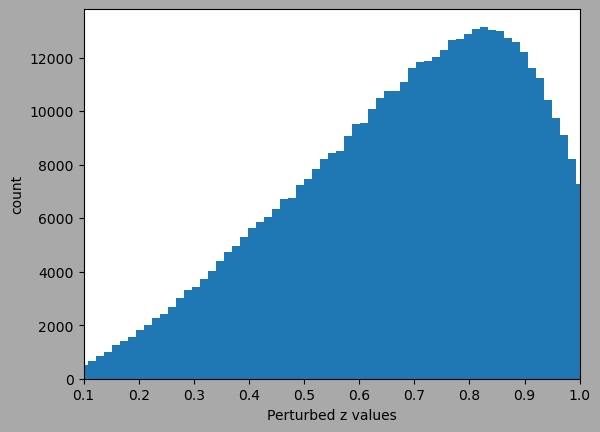

In [85]:
fig,ax = plt.subplots()
fig.set_facecolor('darkgray')
ax.set_xlabel('Perturbed z values')
ax.set_ylabel(r"count")

plt.hist(z_perturbed,bins=100)
plt.xlim(.1,1)

/var/folders/vw/19_m05lx64s_j4tk4nfr1zyc0000gn/T/ipykernel_23996/1093877992.py:3: RuntimeWarning: invalid value encountered in log10
  return m - 25 - 5*np.log10(d) + 2.5*np.log10(1+z)


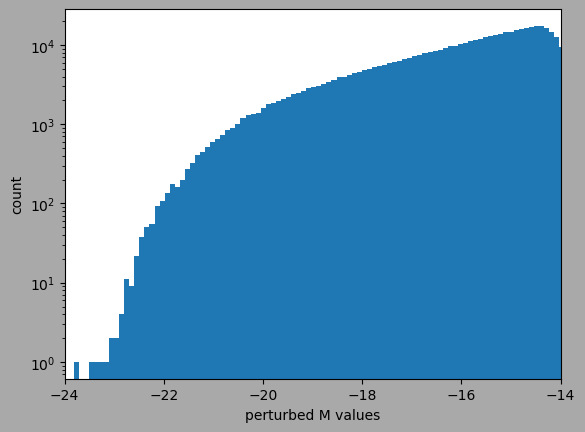

In [86]:
def m_from_M(M, z, Omega_m=OMEGA_M, Omega_lambda=OMEGA_LAMBDA, h=h):
    d = D_L(z, Omega_m, Omega_lambda, h)
    return M + 25 + 5*np.log10(d) - 2.5*np.log10(1+z)

m_observed = m_from_M(M_sample, z_sample)
M_perturbed = M_from_m(m_observed, z_perturbed)

fig,ax = plt.subplots()
fig.set_facecolor('darkgray')
ax.set_xlabel('perturbed M values')
ax.set_ylabel(r"count")

hist, bins, _ = plt.hist(M_perturbed,bins=200)
plt.xlim(M_min,M_max)
plt.yscale('log')

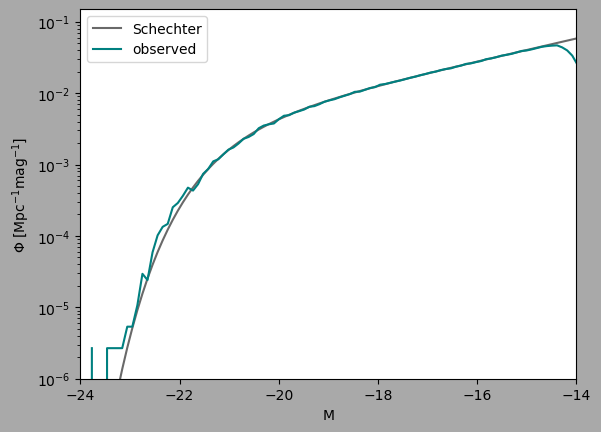

In [87]:
bin_width = bins[1]-bins[0]
bin_centers = 0.5 * (bins[:-1] + bins[1:])
lumin_function = hist/(volume*bin_width)

fig,ax = plt.subplots()
fig.set_facecolor('darkgray')
ax.set_xlabel('M')
ax.set_ylabel(r"$\Phi$ [Mpc$^{-1}$mag$^{-1}$]")

plt.plot(bin_centers, Phi(bin_centers), color = "dimgray", label="Schechter")
plt.plot(bin_centers,lumin_function, color = "teal", label="observed")
plt.xlim(M_min,M_max)
plt.yscale('log')
plt.ylim(1e-6,1.5e-1)
plt.legend()

## back to problem 1...

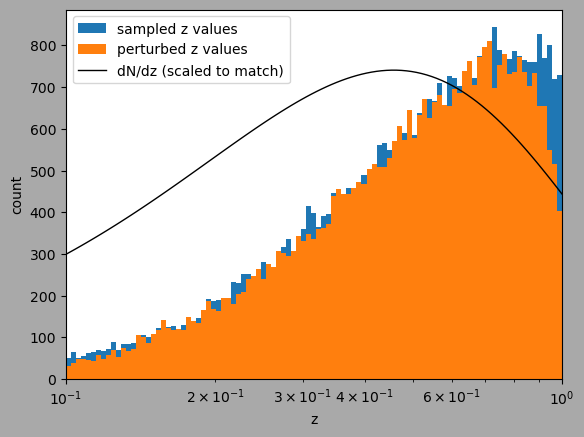

In [143]:
fig,ax = plt.subplots()
fig.set_facecolor('darkgray')
ax.set_xlabel('z')
ax.set_ylabel(r"count")

zs = np.logspace(-1,0,100)
hist, bins, _ = plt.hist(z_sample[m_observed<m_0_DESI],bins=zs, label="sampled z values")
hist, bins, _ = plt.hist(z_perturbed[m_observed<m_0_DESI],bins=zs, label = 'perturbed z values')
plt.xlim(.1,1)
plt.xscale('log')
# plt.yscale('log')
# plt.ylim(1e2,4e4)
bin_width = bins[1]-bins[0]
bin_centers = 0.5 * (bins[:-1] + bins[1:])

# plt.plot(bin_centers,hist)
plt.plot(zs, dNdz(zs,m_0_DESI)/3e6, label="dN/dz (scaled to match)", linewidth=1, color="black")
plt.legend()

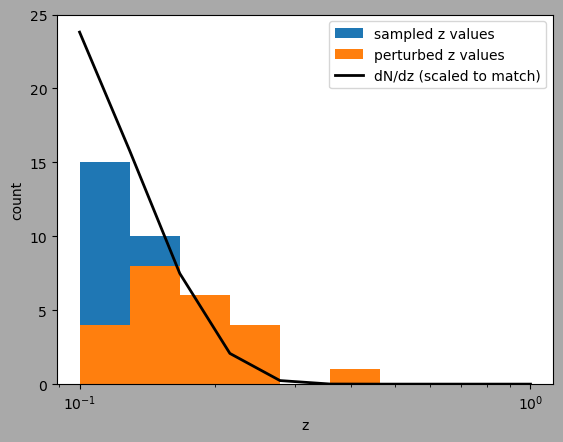

In [144]:
fig,ax = plt.subplots()
fig.set_facecolor('darkgray')
ax.set_xlabel('z')
ax.set_ylabel(r"count")

zs = np.logspace(-1,0,10)
hist, bins, _ = plt.hist(z_sample[m_observed<m_0_SDSS],bins=zs, label="sampled z values")
hist, bins, _ = plt.hist(z_perturbed[m_observed<m_0_SDSS],bins=zs, label = 'perturbed z values')
plt.plot(zs, dNdz(zs,m_0_SDSS)/8.5e5, label="dN/dz (scaled to match)",linewidth=2,color='black')
plt.legend()
plt.xscale('log')

In [90]:
bin_width = bins[1]-bins[0]
bin_centers = 0.5 * (bins[:-1] + bins[1:])